In [17]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 25,10;
sns.set_context('poster',font_scale=1.4);
import pandas as pd;
from collections import namedtuple
from pprint import pprint;
import sys;
from copy import deepcopy;
import pickle;
import pyccl as ccl
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
import scipy

Populating the interactive namespace from numpy and matplotlib


In [14]:
!ls PZ_Project/

DESC_SRD			 cl12.csv	     kcorr.dat
Fishers-Copy1.p			 cl22.csv	     lum_dep_IA.ipynb
Fishers.p			 config.yaml	     nzdist.txt
KDEs.p				 curfisher.p	     outlier_frac.p
Photoz-density-estimation.ipynb  ecorr.dat	     outlier_frac_df.p
Untitled.ipynb			 ell-values.txt      pos_pos_Y10_fid
Untitled1.ipynb			 firecrown.ipynb     pz.csv
Y10_shear_shear_inv.txt		 fisher-Copy1.ipynb  robust scatter.p
__pycache__			 fisher-Copy1.py     robust_bias.p
bias.p				 fisher-Copy2.ipynb  robust_scatter.p
cl00.csv			 fisher-Copy3.ipynb  scatter.p
cl01.csv			 fisher-Copy4.ipynb  shear_shear_Y10_fid
cl02.csv			 fisher.ipynb	     shear_shear_Y10_fid_noIA
cl10.csv			 fisher.py	     token
cl11.csv			 fullFishers.p


In [27]:
Ailist = []
ZEE = []
def getAi(beta, cosmo, dndz, Mr_s=-20.70, Q=1.23, alpha_lum=-1.23, phi_0=0.0094, P=-0.3, mlim=25.3, Lp= 1.):
    """ Get the amplitude of the 2-halo part of w_{l+}
    A0 is the amplitude, beta is the power law exponent (see Krause et al. 2016) 
    cosmo is a CCL cosmology object 
    Lp is a pivot luminosity (default = 1)
    dndz is (z, dNdz) - vector of z and dNdz for the galaxies
    (does not need to be normalised) 
    """
    z_input, dNdz = dndz
    z_input = list(z_input)
    dNdz = list(dNdz)
    (z_k, kcorr, x,x,x) = np.loadtxt('PZ_Project/kcorr.dat', unpack=True)
    (z_e, ecorr, x,x,x) = np.loadtxt('PZ_Project/ecorr.dat', unpack=True)
    zmaxke = min(max(z_k), max(z_e))
    zminke = max(min(z_k), min(z_e))
    if (zminke>min(z_input) and zmaxke<max(z_input)):
        z = np.linspace(zminke, zmaxke, 1000)
        interp_dNdz = scipy.interpolate.interp1d(z_input, dNdz)
        dNdz = interp_dNdz(z)
    elif (zmaxke<max(z_input)):
        z = np.linspace(min(z_input), zmaxke, 1000)
        interp_dNdz = scipy.interpolate.interp1d(z_input, dNdz)
        dNdz = interp_dNdz(z)
    elif (zminke>min(z_input)):
        z = np.linspace(zminke, max(z_input), 1000)
        interp_dNdz = scipy.interpolate.interp1d(z_input, dNdz)
        dNdz = interp_dNdz(z)
    else:
        z = z_input

    # Get the luminosity function
    (L, phi_normed) = get_phi(z, cosmo, Mr_s, Q, alpha_lum, phi_0, P, mlim)
    # Pivot luminosity:
    Lp = 1.

    # Get Ai as a function of lens redshift.
    Ai_ofzl = np.zeros(len(z))
    for zi in range(len(z)):
        Ai_ofzl[zi] = scipy.integrate.simps(np.asarray(phi_normed[zi]) * (np.asarray(L[zi]) / Lp)**(beta), np.asarray(L[zi]))
    Ailist.append(Ai_ofzl)
    ZEE.append(z)
    # Integrate over dNdz
    Ai = scipy.integrate.simps(Ai_ofzl * dNdz, z) / scipy.integrate.simps(dNdz, z)

    return Ai

def get_phi(z, cosmo, Mr_s, Q, alpha_lum, phi_0, P, mlim, Mp=-22.):

    """ This function outputs the Schechter luminosity function with parameters fit in Loveday 2012, following the same procedure as Krause et al. 2015, as a function of z and L 
    The output is L[z][l], list of vectors of luminosity values in z, different at each z due to the different lower luminosity limit, and phi[z][l], a list of luminosity functions at these luminosity vectors, at each z
    cosmo is a CCL cosmology object
    mlim is the magnitude limit of the survey
    Mp is the pivot absolute magnitude.
    other parameteres are the parameters of the luminosity function that are different for different samples, e.g. red vs all. lumparams = [Mr_s, Q, alpha_lum, phi_0, P]
    Note that the luminosity function is output normalized (appropriate for getting Ai)."""

    # Get the amplitude of the Schechter luminosity function as a function of redshift.
    phi_s = phi_0 * 10.**(0.4 * P * z)

    # Get M_* (magnitude), then convert to L_*
    Ms = Mr_s - Q * (z - 0.1)
    Ls = 10**(-0.4 * (Ms - Mp))

    # Import the kcorr and ecorr correction from Poggianti (assumes elliptical galaxies)
    # No data for sources beyon z = 3, so we keep the same value at higher z as z=3
    (z_k, kcorr, x,x,x) = np.loadtxt('PZ_Project/kcorr.dat', unpack=True)
    (z_e, ecorr, x,x,x) = np.loadtxt('PZ_Project/ecorr.dat', unpack=True)
    kcorr_interp = scipy.interpolate.interp1d(z_k, kcorr)
    ecorr_interp = scipy.interpolate.interp1d(z_e, ecorr)
    kcorr = kcorr_interp(z)
    ecorr = ecorr_interp(z)

    # Get the absolute magnitude and luminosity corresponding to limiting apparent magntiude (as a function of z)
    dl = ccl.luminosity_distance(cosmo, 1./(1.+z))
    Mlim = mlim - (5. * np.log10(dl) + 25. + kcorr + ecorr)
    Llim = 10.**(-0.4 * (Mlim-Mp))

    L = [0]*len(z)
    for zi in range(0, len(z)):
        L[zi] = scipy.logspace(np.log10(Llim[zi]), 2., 1000)

    # Now get phi(L,z), where this exists for each z because the lenghts of the L vectors are different.
    phi_func = [0]*len(z)
    for zi in range(0, len(z)):
        phi_func[zi]= np.zeros(len(L[zi]))
        for li in range(0, len(L[zi])):
            phi_func[zi][li] = phi_s[zi] * (L[zi][li] / Ls[zi]) ** (alpha_lum) * np.exp(- L[zi][li] / Ls[zi])

    norm = np.zeros(len(z))
    phi_func_normed = [0]*len(z)
    for zi in range(len(z)):
        norm[zi] = scipy.integrate.simps(phi_func[zi], L[zi])
        phi_func_normed[zi] = phi_func[zi] / norm[zi]

    return (L, phi_func_normed)

In [4]:
dndz = ([0.05,
 0.15,
 0.25,
 0.35,
 0.45,
 0.55,
 0.6500000000000001,
 0.75,
 0.8500000000000001,
 0.95,
 1.05,
 1.15,
 1.25,
 1.35,
 1.4500000000000002,
 1.55,
 1.65,
 1.75,
 1.85,
 1.95,
 2.05,
 2.1500000000000004,
 2.25,
 2.3500000000000005,
 2.45,
 2.55,
 2.6500000000000004,
 2.75,
 2.8500000000000005,
 2.95,
 3.05,
 3.1500000000000004,
 3.25,
 3.3500000000000005,
 3.45,
 3.55,
 3.65,
 3.75,
 3.850000000000001,
 3.95] ,
       [3.35384660e-02, 1.17096134e-01, 2.24722801e-01, 3.77438956e-01,
        4.58826381e-01, 3.73293783e-01, 1.29612895e-01, 2.23690191e-02,
        1.49796301e-02, 1.49127908e-02, 1.38064705e-02, 1.23884050e-02,
        1.11567744e-02, 1.01970722e-02, 9.38081055e-03, 8.54555333e-03,
        7.64623553e-03, 6.82668456e-03, 6.33642603e-03, 6.36016819e-03,
        6.90735054e-03, 7.83588131e-03, 8.97295202e-03, 1.02303646e-02,
        1.16163597e-02, 1.31225008e-02, 1.45644004e-02, 1.55114092e-02,
        1.54126704e-02, 1.39047150e-02, 1.11172950e-02, 7.71413916e-03,
        4.56325740e-03, 2.26732453e-03, 9.34918153e-04, 3.16875353e-04,
        8.76114429e-05, 1.96411004e-05, 3.55288122e-06, 5.16477084e-07])

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.2666, 
                       Omega_b=0.049, 
                       h=0.6727, 
                       sigma8=0.831, 
                       n_s=0.9645, 
                       transfer_function='eisenstein_hu')

In [28]:
getAi(beta=1, cosmo=cosmo, dndz=dndz)

<ipython-input-27-c0120b151a04>:82: DeprecationWarning: scipy.logspace is deprecated and will be removed in SciPy 2.0.0, use numpy.logspace instead
  L[zi] = scipy.logspace(np.log10(Llim[zi]), 2., 1000)


0.20649222856790866

Text(0, 0.5, 'luminosity')

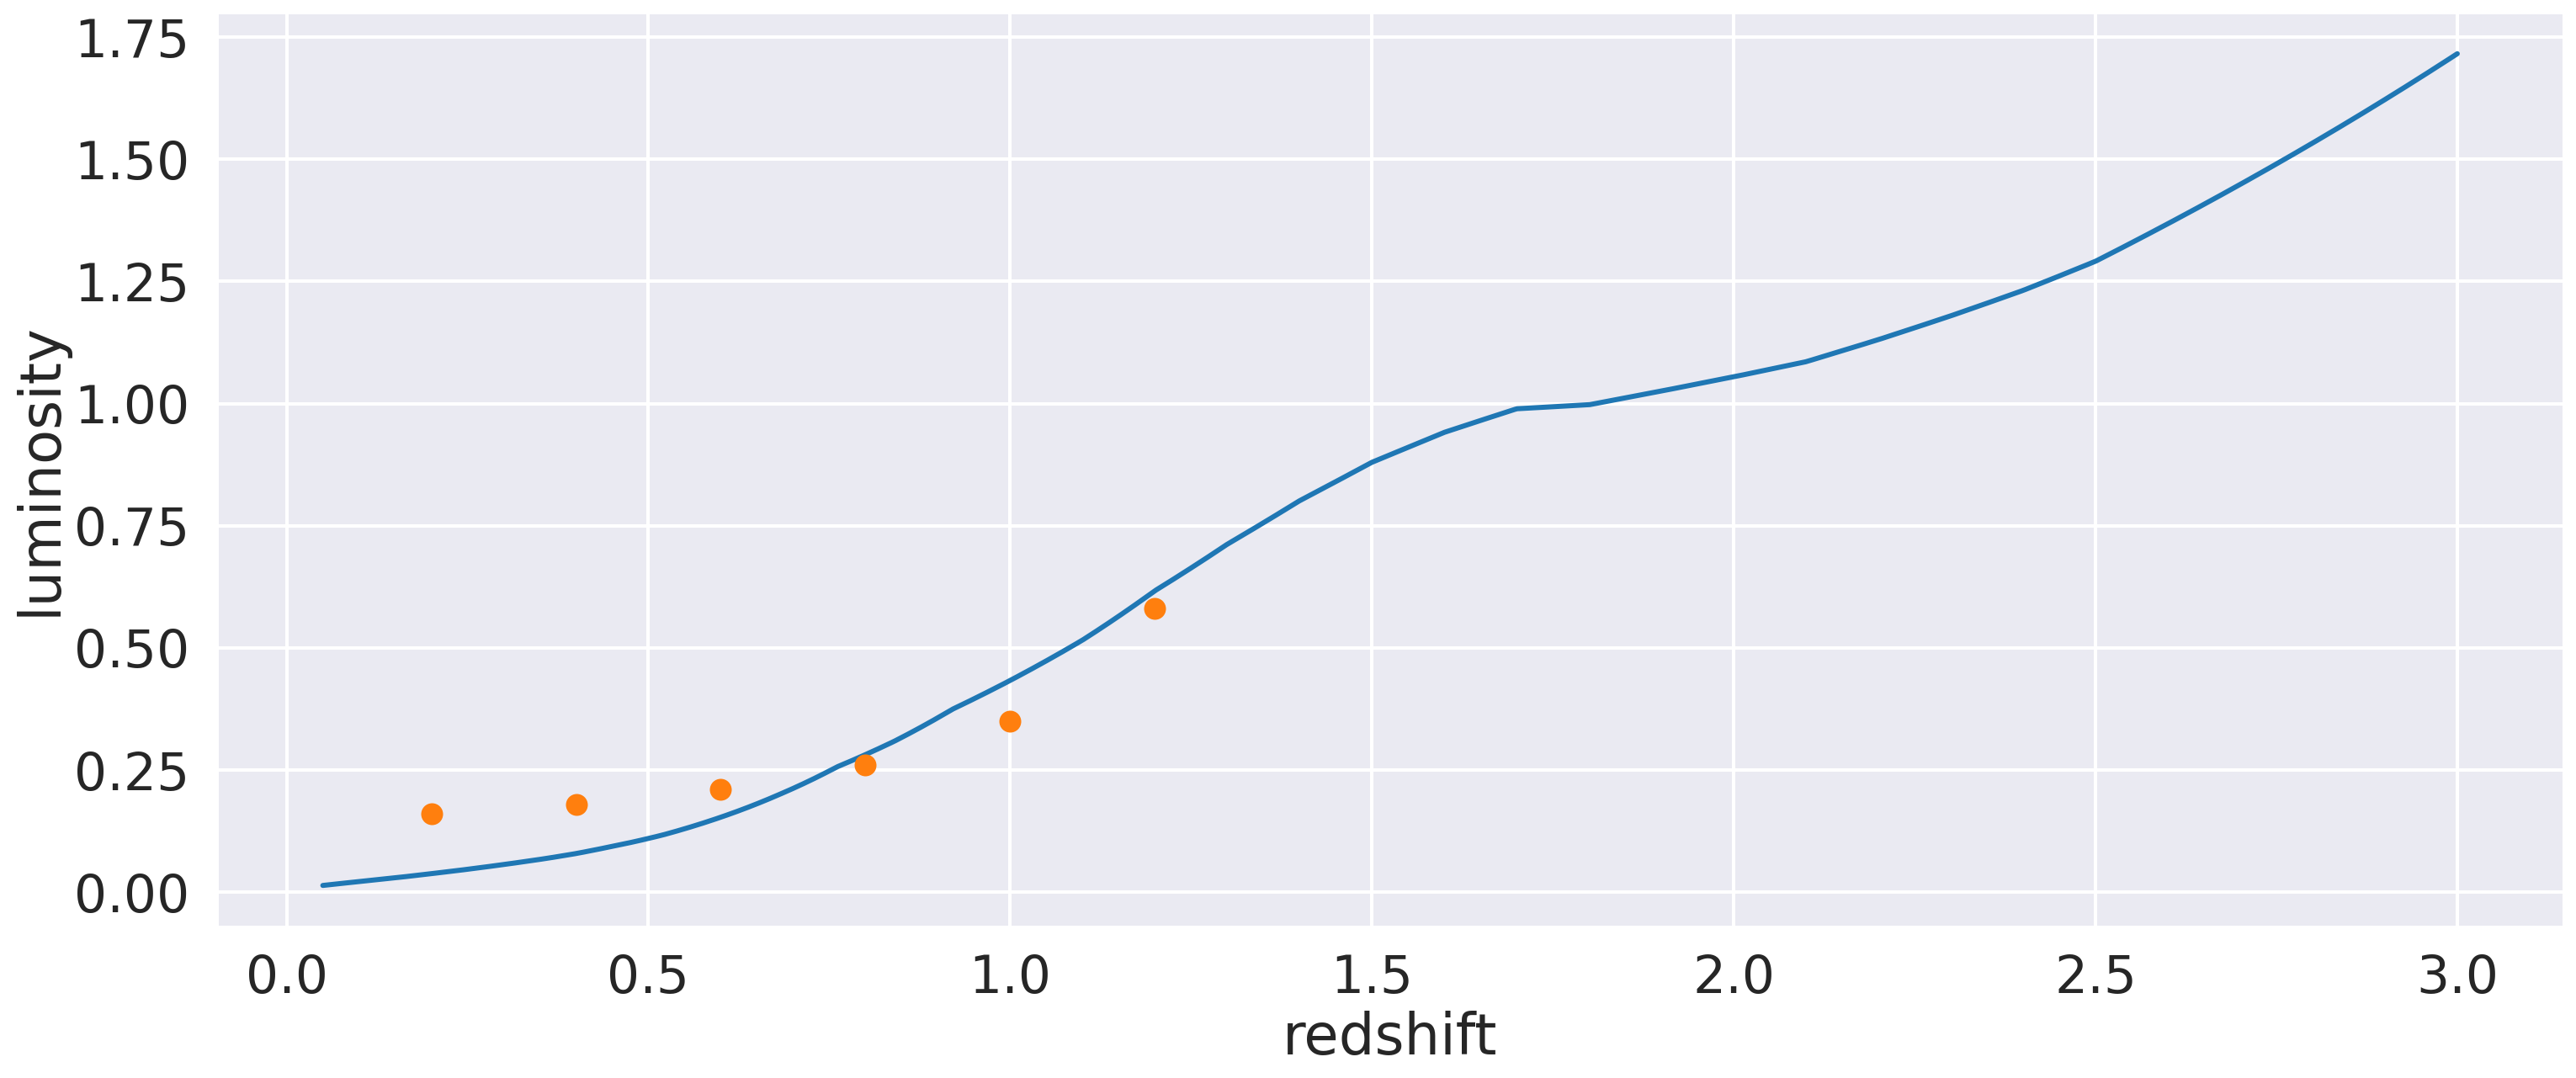

In [32]:
plt.plot(ZEE[0], Ailist[0])
paper_z = np.linspace(0.2,1.2,6)
paper_l = [0.16, 0.18, 0.21, 0.26, 0.35, 0.58]
plt.plot(paper_z, paper_l, 'o')
plt.xlabel('redshift')
plt.ylabel('luminosity')
